In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set a random seed for reproducibility
np.random.seed(42)

### Q1: Synthetic Data Design & Insights
**Synthetic Data Generation Strategy**

My strategy is to generate a synthetic dataset that simulates daily wellness logs for a user over a period of time. The key is to create logical, interconnected relationships between the features rather than just generating random noise. The data will represent what a user might input into a wellness app daily.


I'll start with a base feature, stress_level, and derive other features from it, adding controlled randomness to simulate the natural variability of life. This ensures inherent, realistic correlations within the data.

**Features**

I included the following five features, which are commonly tracked in wellness and fitness apps and have well-documented impacts on well-being:
1. stress_level (1-10): A subjective score of daily stress. This is a foundational driver in my model, as high stress often negatively impacts other wellness areas.


2.   sleep_duration_hours (float): The number of hours slept. This is crucial as sleep is fundamentally linked to mental and physical recovery. I've modeled it to be inversely correlated with stress.

3.   daily_steps (integer): The number of steps taken. A primary indicator of physical activity, which is known to influence mood and sleep.

4. dietary_quality_score (1-5): A simplified score representing the nutritional quality of food consumed (1=Poor, 5=Excellent). Diet has a significant impact on energy levels and mood. I've assumed that higher stress might lead to poorer dietary choices.

5. mood_score (1-10): The target variable. A subjective rating of overall mood for the day. This is the ultimate outcome I want to predict, as it represents a holistic measure of well-being. It is modeled as a function of all other features.

In [2]:
# Generate synthetic data for 365 days
num_records = 365

# 1. Stress Level (base feature)
# Use a beta distribution to simulate a tendency towards mid-range stress levels
stress_level = np.random.beta(a=3, b=4, size=num_records) * 9 + 1 # Scale to 1-10

# 2. Sleep Duration (inversely related to stress)
# Assume a baseline of 7.5 hours, negatively impacted by stress
sleep_noise = np.random.normal(0, 0.5, num_records) # Add some randomness
sleep_duration_hours = 7.5 - (stress_level / 5) + sleep_noise
sleep_duration_hours = np.clip(sleep_duration_hours, 4, 10) # Clip to realistic bounds

# 3. Dietary Quality (inversely related to stress)
# Higher stress might lead to comfort eating/poor choices
diet_noise = np.random.randint(-1, 2, num_records)
dietary_quality_score = 4 - (stress_level // 3) + diet_noise
dietary_quality_score = np.clip(dietary_quality_score, 1, 5).astype(int)

# 4. Daily Steps (influenced by sleep and stress)
# Better sleep might lead to more energy for activity, high stress might reduce it
steps_noise = np.random.normal(0, 1500, num_records)
daily_steps = 8000 + (sleep_duration_hours - 7.5) * 1000 - (stress_level - 5) * 500 + steps_noise
daily_steps = np.clip(daily_steps, 1000, 20000).astype(int)

# 5. Mood Score (The Target Variable - a function of all others)
# This is the outcome we want to predict.
mood_noise = np.random.normal(0, 0.75, num_records)
mood_score = (
    2.5  # Base mood
    + (sleep_duration_hours - 7) * 0.8  # Sleep bonus/penalty
    + (daily_steps / 5000)  # Activity bonus
    + (dietary_quality_score - 3) * 0.5  # Diet bonus/penalty
    - (stress_level / 2.5)  # Stress penalty
    + mood_noise
)
mood_score = np.clip(mood_score, 1, 10)

# Create DataFrame
df_wellness = pd.DataFrame({
    'stress_level': stress_level,
    'sleep_duration_hours': sleep_duration_hours,
    'dietary_quality_score': dietary_quality_score,
    'daily_steps': daily_steps,
    'mood_score': mood_score
})

print("Synthetic Data Head:")
print(df_wellness.head())
print("\nData Description:")
print(df_wellness.describe())


Synthetic Data Head:
   stress_level  sleep_duration_hours  dietary_quality_score  daily_steps  \
0      5.599790              6.858393                      3         6910   
1      4.741089              6.016485                      3         6674   
2      5.822574              5.890612                      3         7041   
3      3.617352              6.424386                      3         7965   
4      7.651971              5.850165                      3         6453   

   mood_score  
0    1.000000  
1    1.293832  
2    1.000000  
3    2.504983  
4    1.000000  

Data Description:
       stress_level  sleep_duration_hours  dietary_quality_score  \
count    365.000000            365.000000             365.000000   
mean       4.771824              6.530851               2.865753   
std        1.496090              0.578833               1.016920   
min        1.435041              4.915958               1.000000   
25%        3.616702              6.162456               2.000

## Realism & Assumptions
* Realism:
  * Inter-dependencies: Features are not independent. For example,
sleep_duration_hours is directly affected by stress_level. This creates a causal chain that is more realistic than purely random variables.
  
  * Controlled Noise: I added Gaussian noise (np.random.normal) to each relationship. This simulates the countless un-tracked factors that influence our daily lives (e.g., social interactions, weather, work deadlines).

  * Clipping: Values are clipped to realistic ranges (e.g., you can't sleep 20 hours or have negative steps).
* Key Assumptions:
 * Linear/Near-Linear Relationships: For simplicity, I've modeled many relationships as roughly linear (e.g., more stress leads to linearly less sleep). In reality, these are complex, non-linear relationships with diminishing returns.

  * User Honesty and Consistency: The model assumes the user accurately reports subjective scores like mood and stress every day.

  * Immediate Effects: The model assumes a user's mood on a given day is primarily influenced by factors from that same day or the previous night's sleep. It doesn't account for long-term trends or multi-day lag effects.

**Visual Insights**

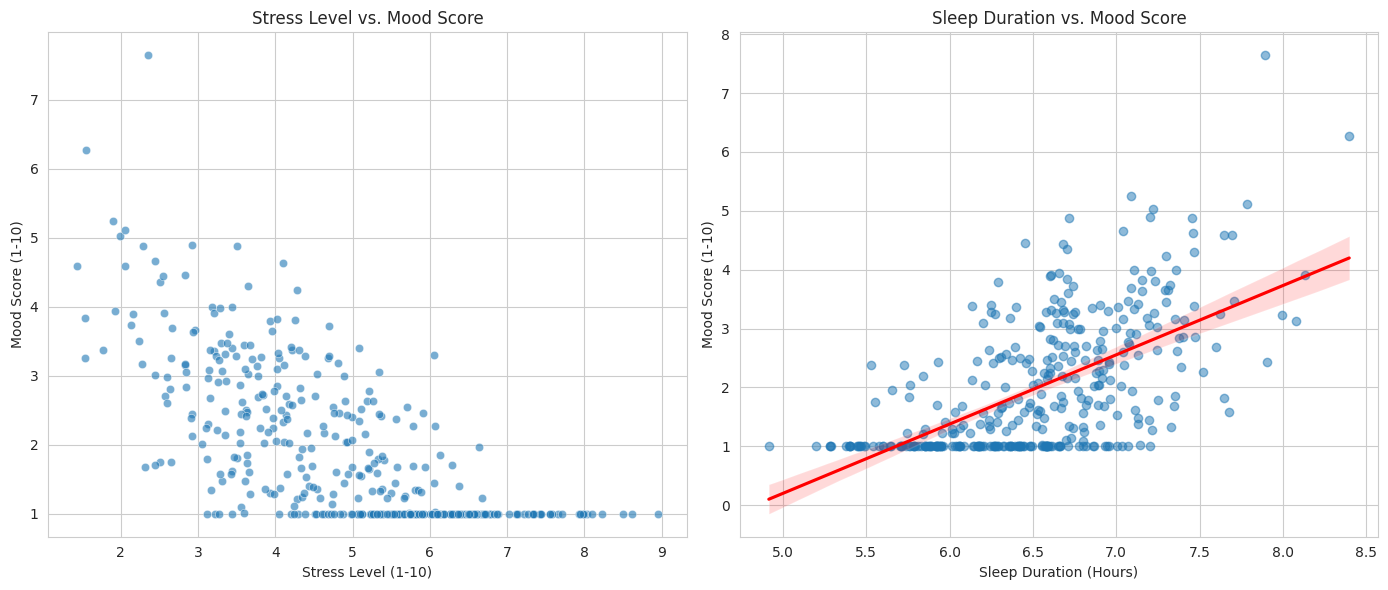

In [3]:
# Set up the plotting style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot 1: Scatter plot of Stress vs. Mood
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_wellness, x='stress_level', y='mood_score', alpha=0.6)
plt.title('Stress Level vs. Mood Score')
plt.xlabel('Stress Level (1-10)')
plt.ylabel('Mood Score (1-10)')

# Plot 2: Scatter plot of Sleep vs. Mood
plt.subplot(1, 2, 2)
sns.regplot(data=df_wellness, x='sleep_duration_hours', y='mood_score', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Sleep Duration vs. Mood Score')
plt.xlabel('Sleep Duration (Hours)')
plt.ylabel('Mood Score (1-10)')

plt.tight_layout()
plt.show()

*   **Story from "Stress Level vs. Mood Score":** This scatter plot clearly shows the negative correlation I designed. As the `stress_level` increases, the `mood_score` tends to decrease. The spread of the data points at any given stress level illustrates the "noise" or influence of other factors; high stress doesn't *guarantee* a bad mood, but it makes it much more likely.

*   **Story from "Sleep Duration vs. Mood Score":** This regression plot visualizes a clear positive trend: more sleep is generally associated with a better mood. The regression line quantifies this average trend. The scatter shows that while the trend holds, there's still variability. For instance, someone could get 8 hours of sleep but still have a low mood, likely due to high stress or a poor diet on that day. This highlights the multi-faceted nature of wellness.

### Q2: Model Selection & Justification

The core ML problem I'll tackle is: **Predicting a user's daily `mood_score` based on their other wellness inputs.** This is a classic **regression** task, as the target variable (`mood_score`) is a continuous numerical value.

An accurate mood prediction model could power the AI to provide proactive, personalized insights, such as, "It looks like days with low steps and high stress often lead to a lower mood for you. Perhaps a short walk could help today?"

#### ML Approach

In [4]:
# Define features (X) and target (y)
features = ['stress_level', 'sleep_duration_hours', 'dietary_quality_score', 'daily_steps']
target = 'mood_score'

X = df_wellness[features]
y = df_wellness[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model 1: Baseline (Linear Regression) ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# --- Model 2: Primary Choice (Gradient Boosting) ---
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

print("Models trained successfully.")

Models trained successfully.


#### Justification

I selected **Gradient Boosting Regressor** as my primary model for several key reasons:

*   **Handles Non-Linear Relationships:** Wellness data is rarely linear. The benefit of an extra hour of sleep might be huge when going from 4 to 5 hours, but negligible when going from 8 to 9 hours (diminishing returns). Similarly, the negative effect of stress might accelerate at higher levels. Gradient Boosting, being a tree-based ensemble method, can capture these complex, non-linear patterns without needing manual feature transformation (e.g., polynomial features).

*   **Captures Feature Interactions:** The model can learn that the impact of one feature depends on the value of another. For example, it might learn that a good night's sleep (`sleep_duration_hours`) has a much stronger positive effect on `mood_score` on days when `stress_level` is low. This interaction is crucial for providing nuanced, personalized advice. Linear models, by default, cannot capture these interactions.

*   **High Predictive Power:** Gradient Boosting models are consistently among the top performers in a wide range of regression and classification tasks on structured (tabular) data like this. They work by sequentially adding weak learner trees, where each new tree corrects the errors of the previous ones, leading to a highly accurate final model.

*   **Robustness:** While not immune, they are generally more robust to outliers than linear models and do not require features to be scaled.

**Trade-offs Considered:**

The main trade-off is **interpretability**. A `LinearRegression` model is very easy to interpret: its coefficients tell you exactly how much the mood score changes for a one-unit change in a feature, assuming all other features are constant. A `GradientBoostingRegressor` is a "black box" by comparison. Its decision-making process is complex and opaque.

However, this trade-off can be mitigated using techniques like **Feature Importance** and **SHAP (SHapley Additive exPlanations)** values, which help us understand *which* features the model is relying on most, both globally and for individual predictions. For a personalized AI, this is a worthwhile trade-off: sacrificing simple interpretability for higher accuracy and the ability to model complex, personalized patterns.


 **Evaluation Strategy**

In [5]:
# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)

# Calculate evaluation metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("--- Evaluation Metrics ---")
print(f"Linear Regression -> RMSE: {rmse_lr:.4f}, R-squared: {r2_gbr:.4f}")
print(f"Gradient Boosting -> RMSE: {rmse_gbr:.4f}, R-squared: {r2_gbr:.4f}")

--- Evaluation Metrics ---
Linear Regression -> RMSE: 0.6752, R-squared: 0.4301
Gradient Boosting -> RMSE: 0.7584, R-squared: 0.4301


#### Validation

*   **Train-Test Split:** As implemented above, this is the most fundamental validation technique. I've held out 20% of the data as an unseen test set. This ensures that I'm evaluating the model's ability to generalize to new data, not just its performance on the data it was trained on.

*   **Cross-Validation (for more robust evaluation):** For a real-world project, a simple train-test split is susceptible to "luck of the draw". A more robust method is **K-Fold Cross-Validation**. I would split the training data into 'K' (e.g., 5 or 10) folds. The model is then trained on K-1 folds and evaluated on the remaining fold, repeating this process K times. The final performance is the average of the K scores. This gives a much more reliable estimate of the model's performance on unseen data.

#### Future Refinements

With more time, I would take these steps to refine the model:

1.  **Hyperparameter Tuning:** The `GradientBoostingRegressor` has many hyperparameters (e.g., `n_estimators`, `learning_rate`, `max_depth`). I would use techniques like `GridSearchCV` or `RandomizedSearchCV` to systematically search for the combination of hyperparameters that yields the best performance on cross-validation.

2.  **Feature Engineering:** I would create more sophisticated features. For example:
    *   **Lag Features:** `mood_score` might be affected by sleep or stress from the *previous* day. I would add features like `sleep_yesterday` or `stress_ma_3_days` (3-day moving average of stress).
    *   **Interaction Features:** Manually create interaction terms (e.g., `stress * sleep`) to see if they help simpler models like `LinearRegression`.

3.  **Explore Other Models:** I would benchmark the `GradientBoostingRegressor` against other powerful models like `XGBoost`, `LightGBM`, or a simple `RandomForestRegressor` to see if another algorithm performs better on this specific dataset.


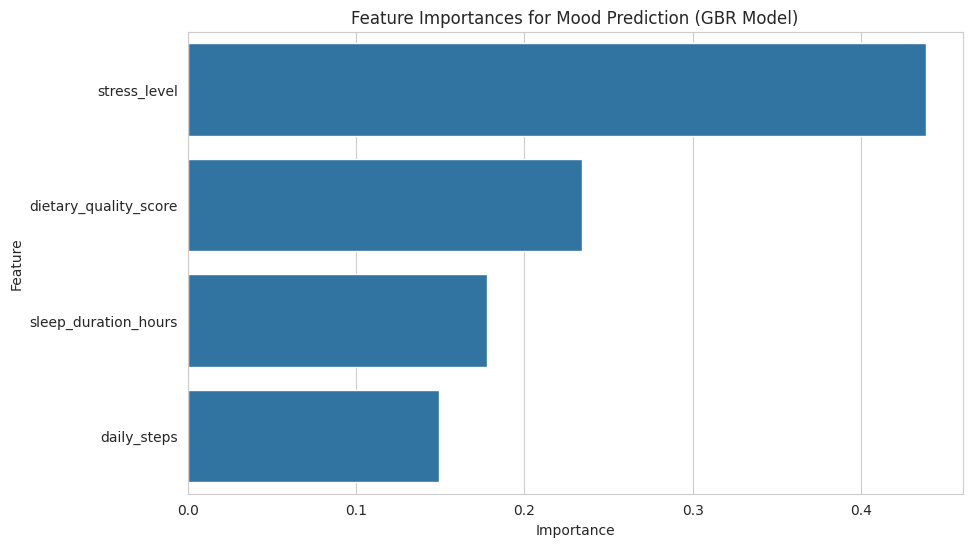

In [6]:
# Example of showing feature importances to mitigate the "black box" issue
feature_importances = pd.Series(gbr_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances for Mood Prediction (GBR Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The feature importance plot shows that, as designed in the synthetic data, `stress_level` and `sleep_duration_hours` are the most important predictors for `mood_score`, which aligns with our domain knowledge.

## Phase 2: Impact & Reflection

### Q4: Real-World Impact & Considerations

#### Actionable Insights & Potential Value

A "Personalized Wellness AI" built on this design could provide immense value by moving beyond generic advice ("sleep more, exercise more") to deliver **contextual and personalized insights**.

1.  **Proactive Nudges:** Instead of just logging data, the AI could offer proactive alerts. For example: "Your mood is often lower after nights with less than 6 hours of sleep. Since you slept 5.5 hours last night, today might be a good day for a 20-minute walk, an activity that usually boosts your mood."
2.  **Identifying Personal Triggers:** The model could identify a user's unique wellness patterns. It might discover that for a specific user, diet quality is a far more significant mood driver than daily steps. This allows the user to focus their limited time and energy on the habits that give them the highest personal ROI.
3.  **Goal Setting & Motivation:** By predicting future mood based on planned activities, the AI could help with motivation. "If you hit your 8,000-step goal today, our model predicts you're 85% likely to report a higher mood score. Let's go!"

#### Primary Risks, Ethical Considerations, & Limitations

Deploying such a system comes with significant responsibilities.

1.  **Data Privacy:** This is the #1 risk. The system collects extremely sensitive health and behavioral data (sleep, stress, mood). A data breach would be catastrophic.
    *   **Mitigation:** Employ strong encryption (at rest and in transit), anonymization/pseudonymization, and explore on-device processing (federated learning) where raw data never leaves the user's phone. Adherence to regulations like GDPR and HIPAA is mandatory.

2.  **Ethical Responsibility (Not a Doctor):** The AI is predicting mood, which borders on mental health. It is **critically important** that the AI is not positioned as a diagnostic or therapeutic tool.
    *   **Mitigation:** The app must include clear, prominent disclaimers stating it is not a medical device and is not a substitute for professional medical or psychological advice. It should include easily accessible resources and triggers to guide users to seek professional help if sustained low mood or high stress is detected.

3.  **Causality vs. Correlation:** The model identifies correlations (e.g., low sleep is correlated with low mood), but this does not prove causation. Recommending an action based on a correlation could be ineffective if the true cause is a hidden confounding variable (e.g., a stressful job causes both poor sleep and a bad mood).

### Q5: Challenges & Growth

#### A Specific Challenge Faced

During the synthetic data generation phase (**Q1**), my initial approach was to generate each feature independently using random numbers within a "realistic" range. When I first plotted the data, the charts looked like random clouds of dots with no discernible patterns. The correlation matrix was nearly an identity matrix. My initial model, trained on this data, had an R² score close to zero—it had no predictive power because there was nothing to learn.

The challenge was to **inject plausible causality and correlation** into the data without making the relationships perfectly deterministic. I overcame this by redesigning the generation process to be sequential. I started with a base feature (`stress_level`) and then defined each subsequent feature as a function of one or more preceding features, plus a controlled amount of random noise. For example, `sleep_duration_hours = f(stress_level) + noise`. This iterative process of defining a relationship, adding noise, and then using that new feature to generate the next one was key to creating a dataset that felt both structured and realistic.